# ****

---

## **Overview**

This project analyzes California housing prices from the 1990 census.  The data was downloaded from [www.kaggle.com - California Housing Prices](https://www.kaggle.com/camnugent/california-housing-prices).  The dataset was downloaded from kaggle and placed onto a public folder in DropBox.  The data can be downloaded from [here](https://www.dropbox.com/s/nj5cj6mkmmkdrjv/housing.csv?dl=1).

The general approach to the analysis was:

* Clean up data by identifying and correcting missing values and outliers.
* Look for correlations and trends in the data
* Running multiple linear regression models designed to predict prices (`median_house_value`)

## **Key Points**
* The data has rows that are missing values for `total bedrooms`
* Housing prices are clipped at a maximum of $500,001
* House ages are clipped at a maximum of 52 years
* There appears to be erroneous data in the `total_rooms`, `total_bedrooms`, and `total_population` values that produce significant outliers.
* There appears to be a strong relationship between `median_income` and `median_house_value`.
* Even though many features do not strongly correlate to `median_house_value`, the inclusion of these features in the linear model improves its accuracy.



In [ ]:
import numpy as np # numerical operations
import matplotlib.pyplot as plt # More traditional
import pandas as pd  # reading in data into tabular format
import seaborn as sns  # New and easy format plot library
from sklearn.metrics import r2_score # Evaluation, rss
from sklearn.preprocessing import LabelEncoder,StandardScaler
import io

%matplotlib inline 

# Load California Housing Dataset 
# Originally downloaded from: https://www.kaggle.com/camnugent/california-housing-prices
url = 'https://www.dropbox.com/s/nj5cj6mkmmkdrjv/housing.csv?dl=1'
cali_dataset=pd.read_csv(url)

# Save the original datset for future use
cali_original = cali_dataset.copy()
cali_dataset.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# Functions to help with formatting
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

def printHorizontalRule():
  printmd("---")

In [ ]:
# Review structure of dataset.
# 
# total_bedrooms has 207 rows that contain nulls
# ocean_proximity is a non-numeric type
printmd("**California housing dataset structure**")
cali_dataset.info()

**California housing dataset structure**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# Clean up total_bedrooms.
# total_bedrooms has missing data.
printmd("**Rows with missing values**")
print(cali_dataset.isnull().sum())

# These rows could be removed or they can be updated with default values.
# We will update the missing values with average number of rooms from the dataset.

# Update rows with empty total_bedrooms
cali_dataset["total_bedrooms"]=cali_dataset["total_bedrooms"].fillna(cali_dataset["total_bedrooms"].mean())
print()
printmd("**Rows after setting missing total_bedrooms to mean**")
print(cali_dataset.isnull().sum())

**Rows with missing values**

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64



**Rows after setting missing total_bedrooms to mean**

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


# New Section

In [ ]:
# ocean_proximity is an 'object' type.  Convert the contents of this field to something 
# more useful.  Options would be to convert it to a numeric field or to 
# create individual boolean (1/0) columns for each value
printmd("**`ocean_proximity` value counts**")
print(cali_dataset["ocean_proximity"].value_counts())

# Create columns for each proximity category so each of the values of ocean_proxity
# will become columns in the output dataset cali_dataset_clean
# <1H OCEAN     9136
# INLAND        6551
# NEAR OCEAN    2658
# NEAR BAY      2290
# ISLAND           5

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
cali_dataset = cali_dataset.join(pd.DataFrame(
                          lb.fit_transform(cali_dataset["ocean_proximity"]),
                          columns=lb.classes_, 
                          index=cali_dataset.index))

cali_dataset = cali_dataset.drop(columns=["ocean_proximity"])

print()
printmd("**`ocean_proximity` values converted to columns**")
cali_dataset.head()

**`ocean_proximity` value counts**

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64



**`ocean_proximity` values converted to columns**

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


In [ ]:
# Calculate some additional columns to look for other correlations

# Per household numbers might provide more information than bulk values across an area.
# Calculate per-household room, bedroom, and population values
cali_dataset['bedrooms_per_household'] = cali_dataset["total_bedrooms"] / cali_dataset['households']
cali_dataset["rooms_per_household"] = cali_dataset["total_rooms"] / cali_dataset['households']
cali_dataset["population_per_household"] = cali_dataset["population"] / cali_dataset['households']

In [ ]:
# Look at the current structure of the dataset after adding additional fields
printmd("**Added bedrooms_per_household, rooms_per_household, population_per_household**")
cali_dataset.describe()

**Added bedrooms_per_household, rooms_per_household, population_per_household**

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedrooms_per_household,rooms_per_household,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,0.442636,0.317393,0.000242,0.110950,0.128779,1.104422,5.429000,3.070655
std,2.003532,2.135952,12.585558,2181.615252,419.266592,1132.462122,382.329753,1.899822,115395.615874,0.496710,0.465473,0.015563,0.314077,0.334963,0.544522,2.474173,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149866,0.846154,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.005857,4.440716,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,438.000000,1166.000000,409.000000,3.534800,179700.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.049084,5.229129,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.100398,6.052381,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,34.066667,141.909091,1243.333333


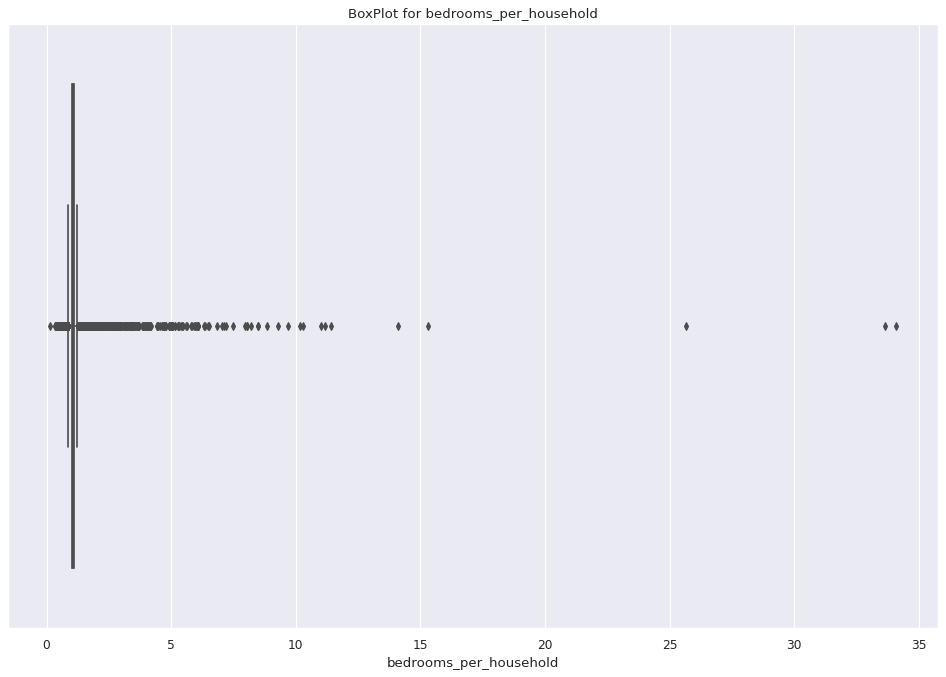

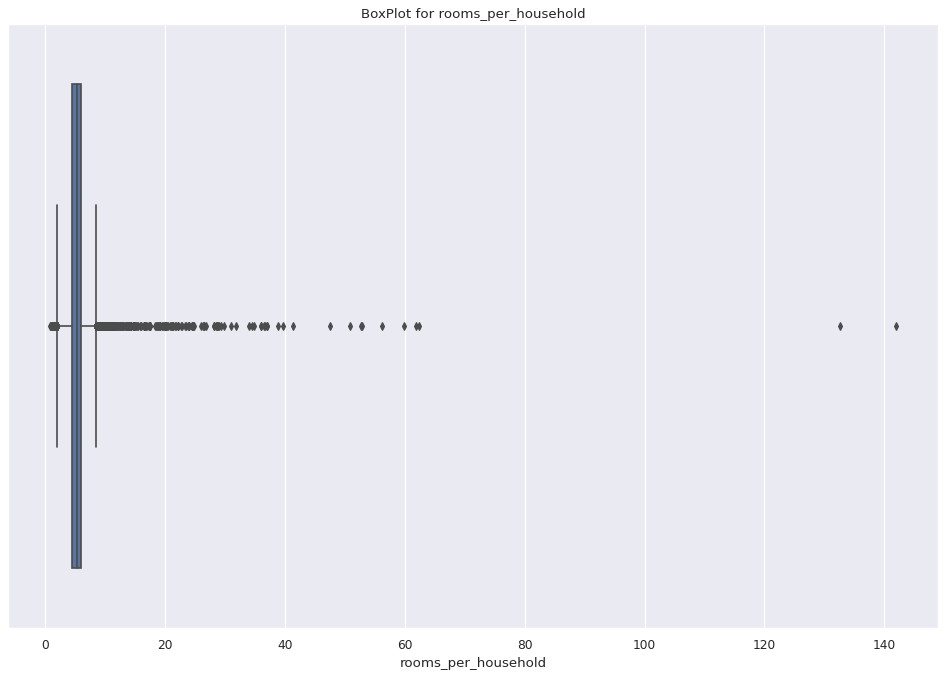

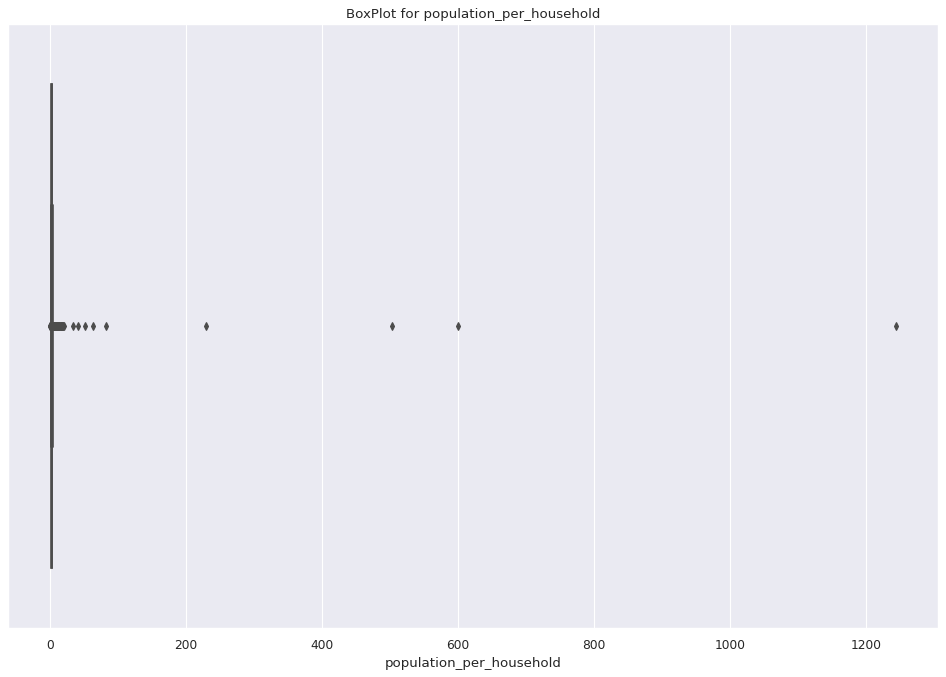

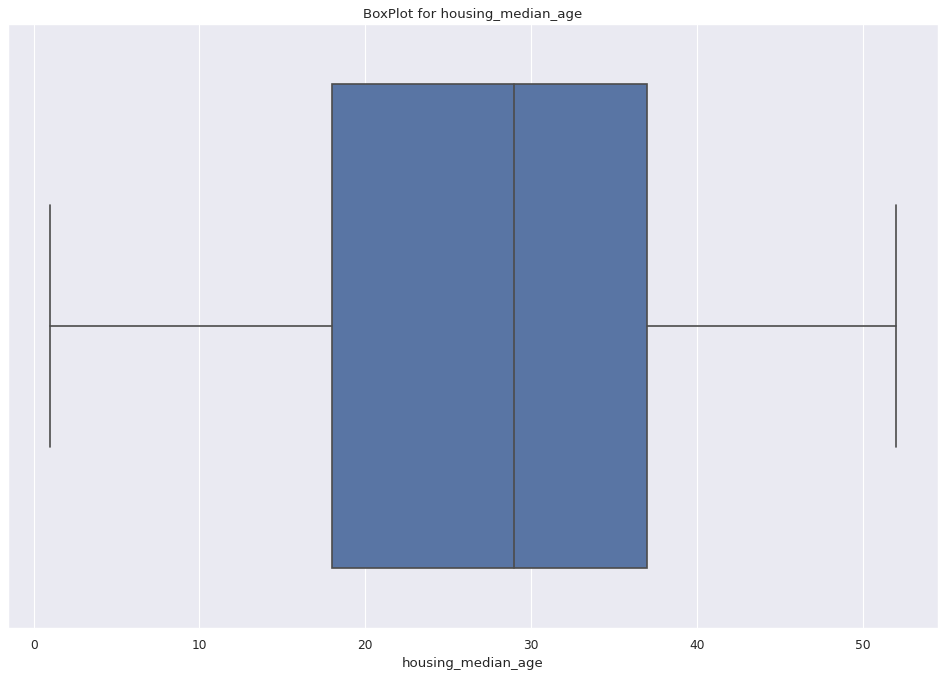

In [ ]:
# Look for outliers in the data.  These may be removed or adjusted to improve the results
# Generate boxplots to look for outliers in specific features

# These columns have been identified as having unusual maximum values
for column in ['bedrooms_per_household', 'rooms_per_household', 'population_per_household', 'housing_median_age']:
    plt.figure(figsize=(15, 10), dpi=80)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plt.title("BoxPlot for " + column + "")
    sns.boxplot(x=cali_dataset[column])


In [ ]:
# Based on the boxplots, identify outliers and remove those records.
#
# Cleanup the data set
#
cali_dataset_clean = cali_dataset.copy()

#
# Bedrooms per household outliers up to 35 which seem to indicate erroneous data
#
cali_dataset_clean = cali_dataset_clean[cali_dataset_clean["bedrooms_per_household"] < 14]

#
# Rooms per household has outliers up to 140 rooms which seems to indicate erroneous data
#
cali_dataset_clean = cali_dataset_clean[cali_dataset_clean["rooms_per_household"] < 14]

#
# Population per household has outliers up to 1,200 people per household which is clearly incorrect.
#
cali_dataset_clean = cali_dataset_clean[cali_dataset_clean["population_per_household"] < 20]

In [ ]:
cali_dataset_clean.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedrooms_per_household,rooms_per_household,population_per_household
count,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000
mean,-119.572332,35.622536,28.701239,2633.353911,537.520496,1430.346255,501.851619,3.870051,207051.899551,0.445338,0.313439,0.000244,0.111664,0.129315,1.077887,5.305423,2.935337
std,2.004801,2.131632,12.572017,2178.905560,418.778986,1129.547155,382.338179,1.898224,115473.738416,0.497015,0.463902,0.015613,0.314960,0.335557,0.211674,1.299709,0.866215
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149866,0.846154,0.750000
25%,-121.800000,33.930000,18.000000,1448.000000,297.000000,793.000000,282.000000,2.562500,119700.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.005525,4.435897,2.432220
50%,-118.490000,34.250000,29.000000,2126.000000,438.000000,1170.000000,411.000000,3.534300,180000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.048599,5.220864,2.821930
75%,-118.010000,37.710000,37.000000,3143.250000,643.000000,1728.000000,606.250000,4.744000,265200.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.099186,6.030061,3.283758
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.027919,13.985507,19.312500


housing_median_age
52.0                  1269
36.0                   859
35.0                   824
16.0                   759
17.0                   689
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


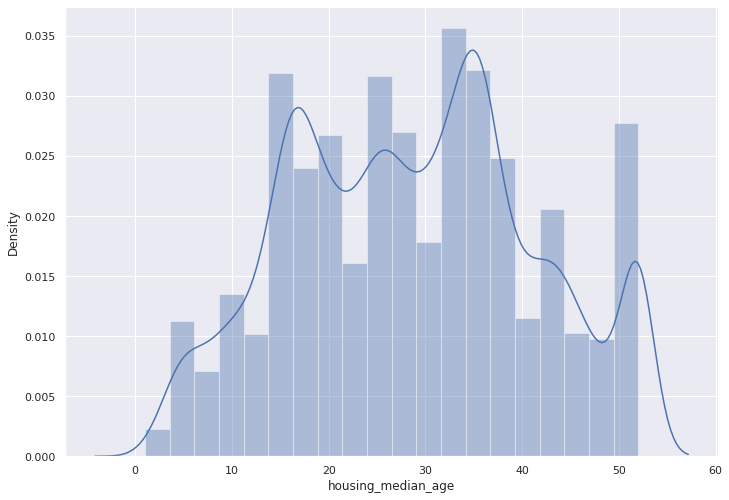

In [ ]:
# 
# House ages appear clipped at 52 years.  There are significantly
# more houses in the 52 year bucket.
#
print(cali_dataset_clean[["housing_median_age"]].value_counts().head())

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(cali_dataset_clean["housing_median_age"], bins=20)

cali_dataset_clean = cali_dataset_clean[cali_dataset_clean["housing_median_age"] < 52]

In [ ]:
#
# Homes with a proximity of 'island' may be outliers so look at the range of house values for homes on islands
#

# There are only 5 records on 'islands' and their values are much higher than average.
island = cali_dataset_clean[cali_dataset_clean["ISLAND"] == 1]
printmd("**Homes on islands**: {}".format(len(island.index)))
island["median_house_value"].describe()
island.head(n=len(island.index))

**Homes on islands**: 2

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedrooms_per_household,rooms_per_household,population_per_household
8314,-118.32,33.35,27.0,1675.0,521.0,744.0,331.0,2.1579,450000.0,0,0,1,0,0,1.574018,5.060423,2.247734
8318,-118.48,33.43,29.0,716.0,214.0,422.0,173.0,2.6042,287500.0,0,0,1,0,0,1.236994,4.138728,2.439306


In [ ]:
# Remove rows for homes on 'islands'
cali_dataset_clean = cali_dataset_clean[cali_dataset_clean["ISLAND"] != 1]

In [ ]:
#
# Review median_house_value for outliers
#

# Data appears clipped at $500001 since there are 960 rows with this value
printmd("**`median_house_value` value counts**")
print(cali_dataset_clean[cali_dataset_clean['median_house_value']>450000]['median_house_value'].value_counts().head())

# Note: Removing outlier house values reduced the r2 score so these rows aren't being removed
#cali_dataset_clean = cali_dataset_clean[cali_dataset_clean["median_house_value"] < 500001.0]

**`median_house_value` value counts**

500001.0    791
500000.0     17
475000.0      6
483300.0      5
451300.0      3
Name: median_house_value, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


**Cleaned dataset**

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedrooms_per_household,rooms_per_household,population_per_household
count,19237.000000,19237.000000,19237.000000,19237.000000,19237.000000,19237.000000,19237.000000,19237.000000,19237.000000,19237.000000,19237.000000,19237.0,19237.000000,19237.000000,19237.000000,19237.000000,19237.000000
mean,-119.485431,35.557732,27.164371,2684.281697,546.261800,1463.513126,509.955243,3.869566,202526.879867,0.457608,0.324947,0.0,0.086500,0.130946,1.078193,5.319522,2.956407
std,1.976451,2.128962,11.416044,2226.782423,426.352748,1151.429795,389.204749,1.868959,112283.421791,0.498213,0.468367,0.0,0.281108,0.337350,0.212383,1.292248,0.854850
min,-124.300000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.149866,0.846154,0.750000
25%,-121.590000,33.920000,18.000000,1464.000000,300.000000,809.000000,285.000000,2.566700,118300.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.005291,4.447500,2.458065
50%,-118.450000,34.220000,27.000000,2157.000000,444.000000,1198.000000,416.000000,3.540300,176500.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.048193,5.237832,2.845401
75%,-117.980000,37.640000,36.000000,3204.000000,653.000000,1772.000000,615.000000,4.760900,257800.000000,1.000000,1.000000,0.0,0.000000,0.000000,1.099057,6.045918,3.303704
max,-114.310000,41.950000,51.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,0.0,1.000000,1.000000,8.027919,13.985507,19.312500


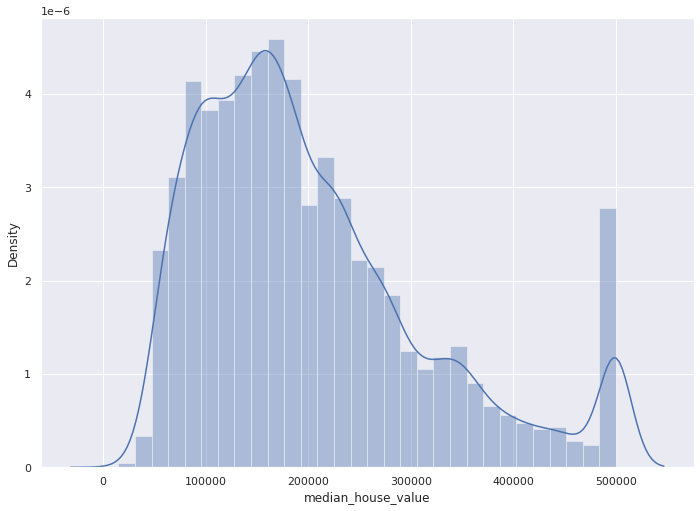

In [ ]:
# Look at the cleaned dataset so far
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(cali_dataset_clean["median_house_value"], bins=30)

print()
printmd("**Cleaned dataset**")
cali_dataset_clean.describe()

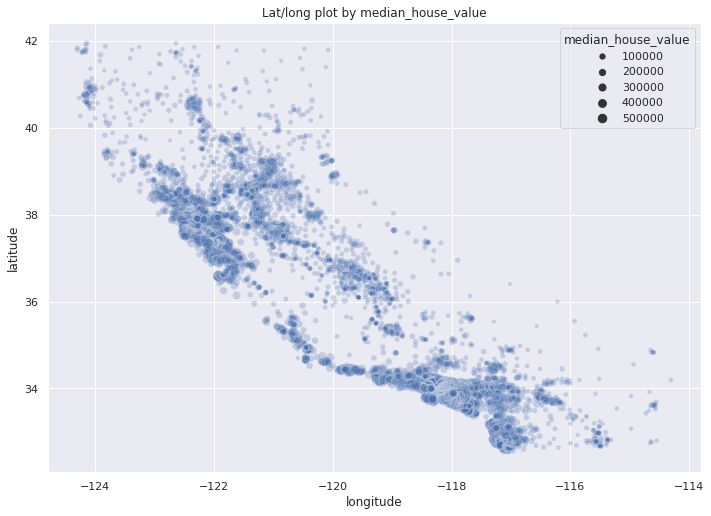

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


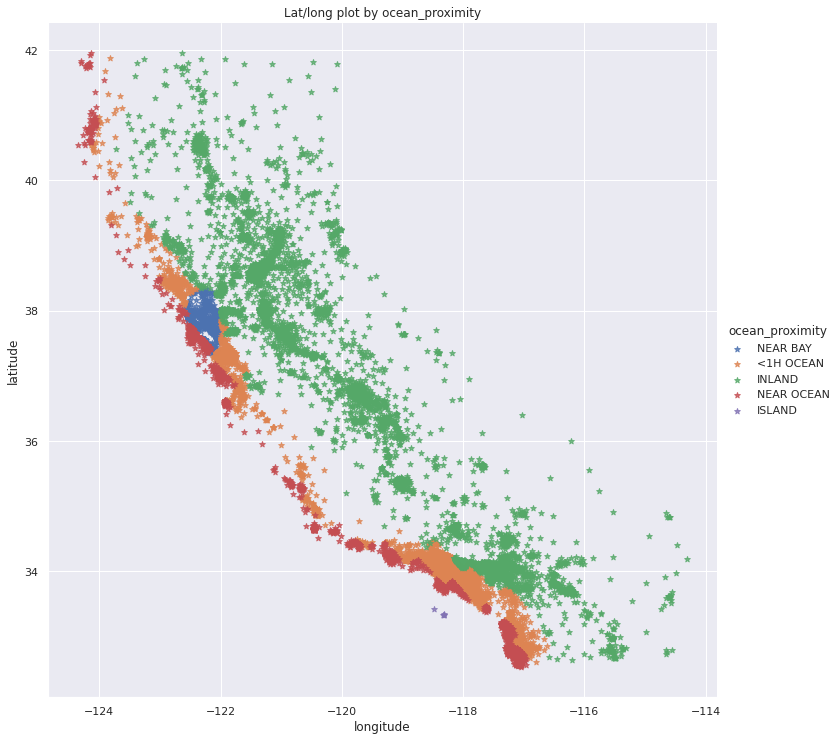

In [ ]:
#
# Look for any correlation between lat/long and value
#

# There are definitely clusters of data but there isn't a clear relationship

# Look at prices based on lat/long
sns.scatterplot(x=cali_dataset_clean['longitude'], 
                y=cali_dataset_clean['latitude'], 
                size=cali_dataset_clean['median_house_value'], 
                alpha=0.25)
plt.title("Lat/long plot by median_house_value")
plt.show()

# Look at groups of houses based on proximity to the ocean
sns.lmplot('longitude', 'latitude', data=cali_original,markers = '*', hue='ocean_proximity', fit_reg=False, height=10, )
plt.title("Lat/long plot by ocean_proximity")
plt.show()


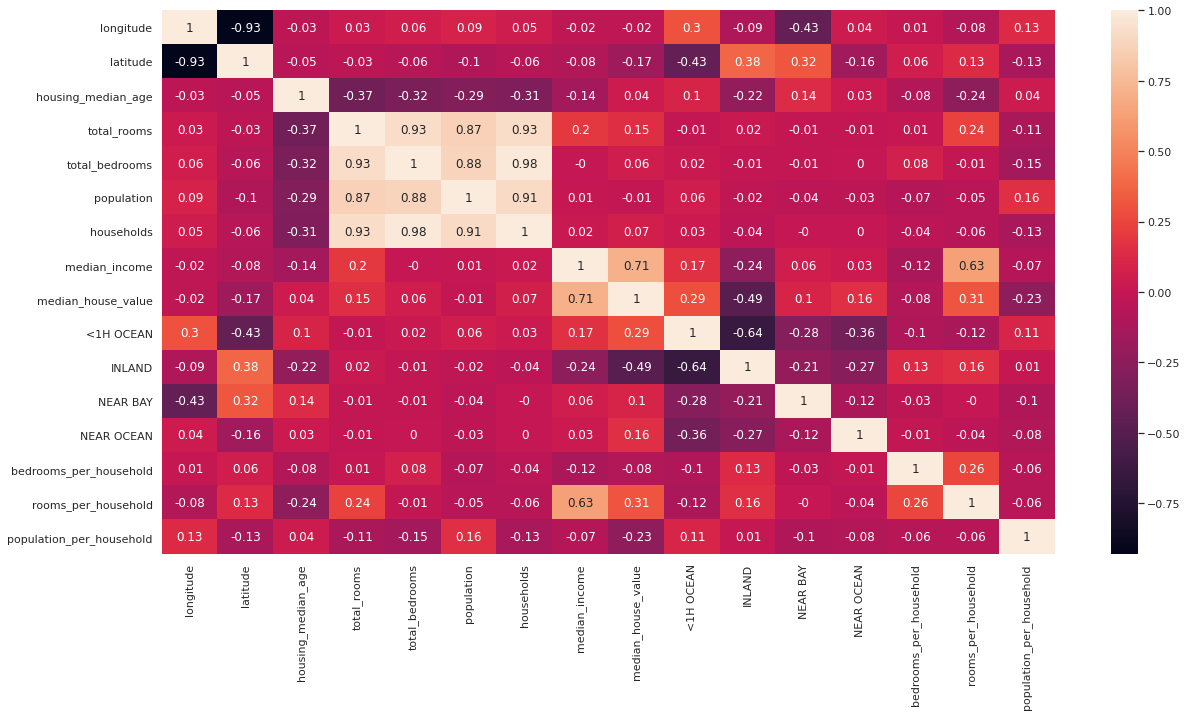

In [ ]:
#
# Calculate correlations between all variables
# 
correlation_matrix = cali_dataset_clean.corr(min_periods=100).round(2)
correlation_matrix["median_house_value"] = correlation_matrix["median_house_value"].sort_values(ascending=False)
correlation_matrix = correlation_matrix.drop(columns=['ISLAND'])
correlation_matrix = correlation_matrix.drop(labels=['ISLAND'])
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, annot=True)

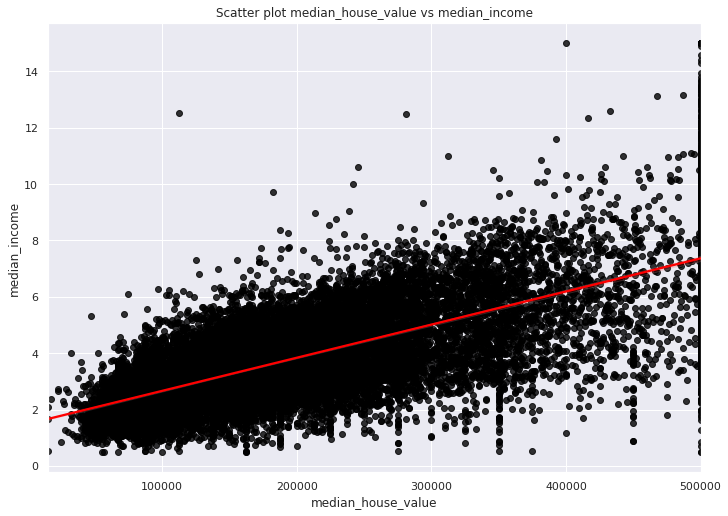

In [ ]:
#
# The strongest relationship seems to be between median_income and median_house_value
#

# Plotting this relationship shows a clear positive correlation
sns.regplot(x=cali_dataset_clean['median_house_value'], y=cali_dataset_clean['median_income'], color='black', line_kws={"color": "red"})
plt.title("Scatter plot median_house_value vs median_income")
plt.show()

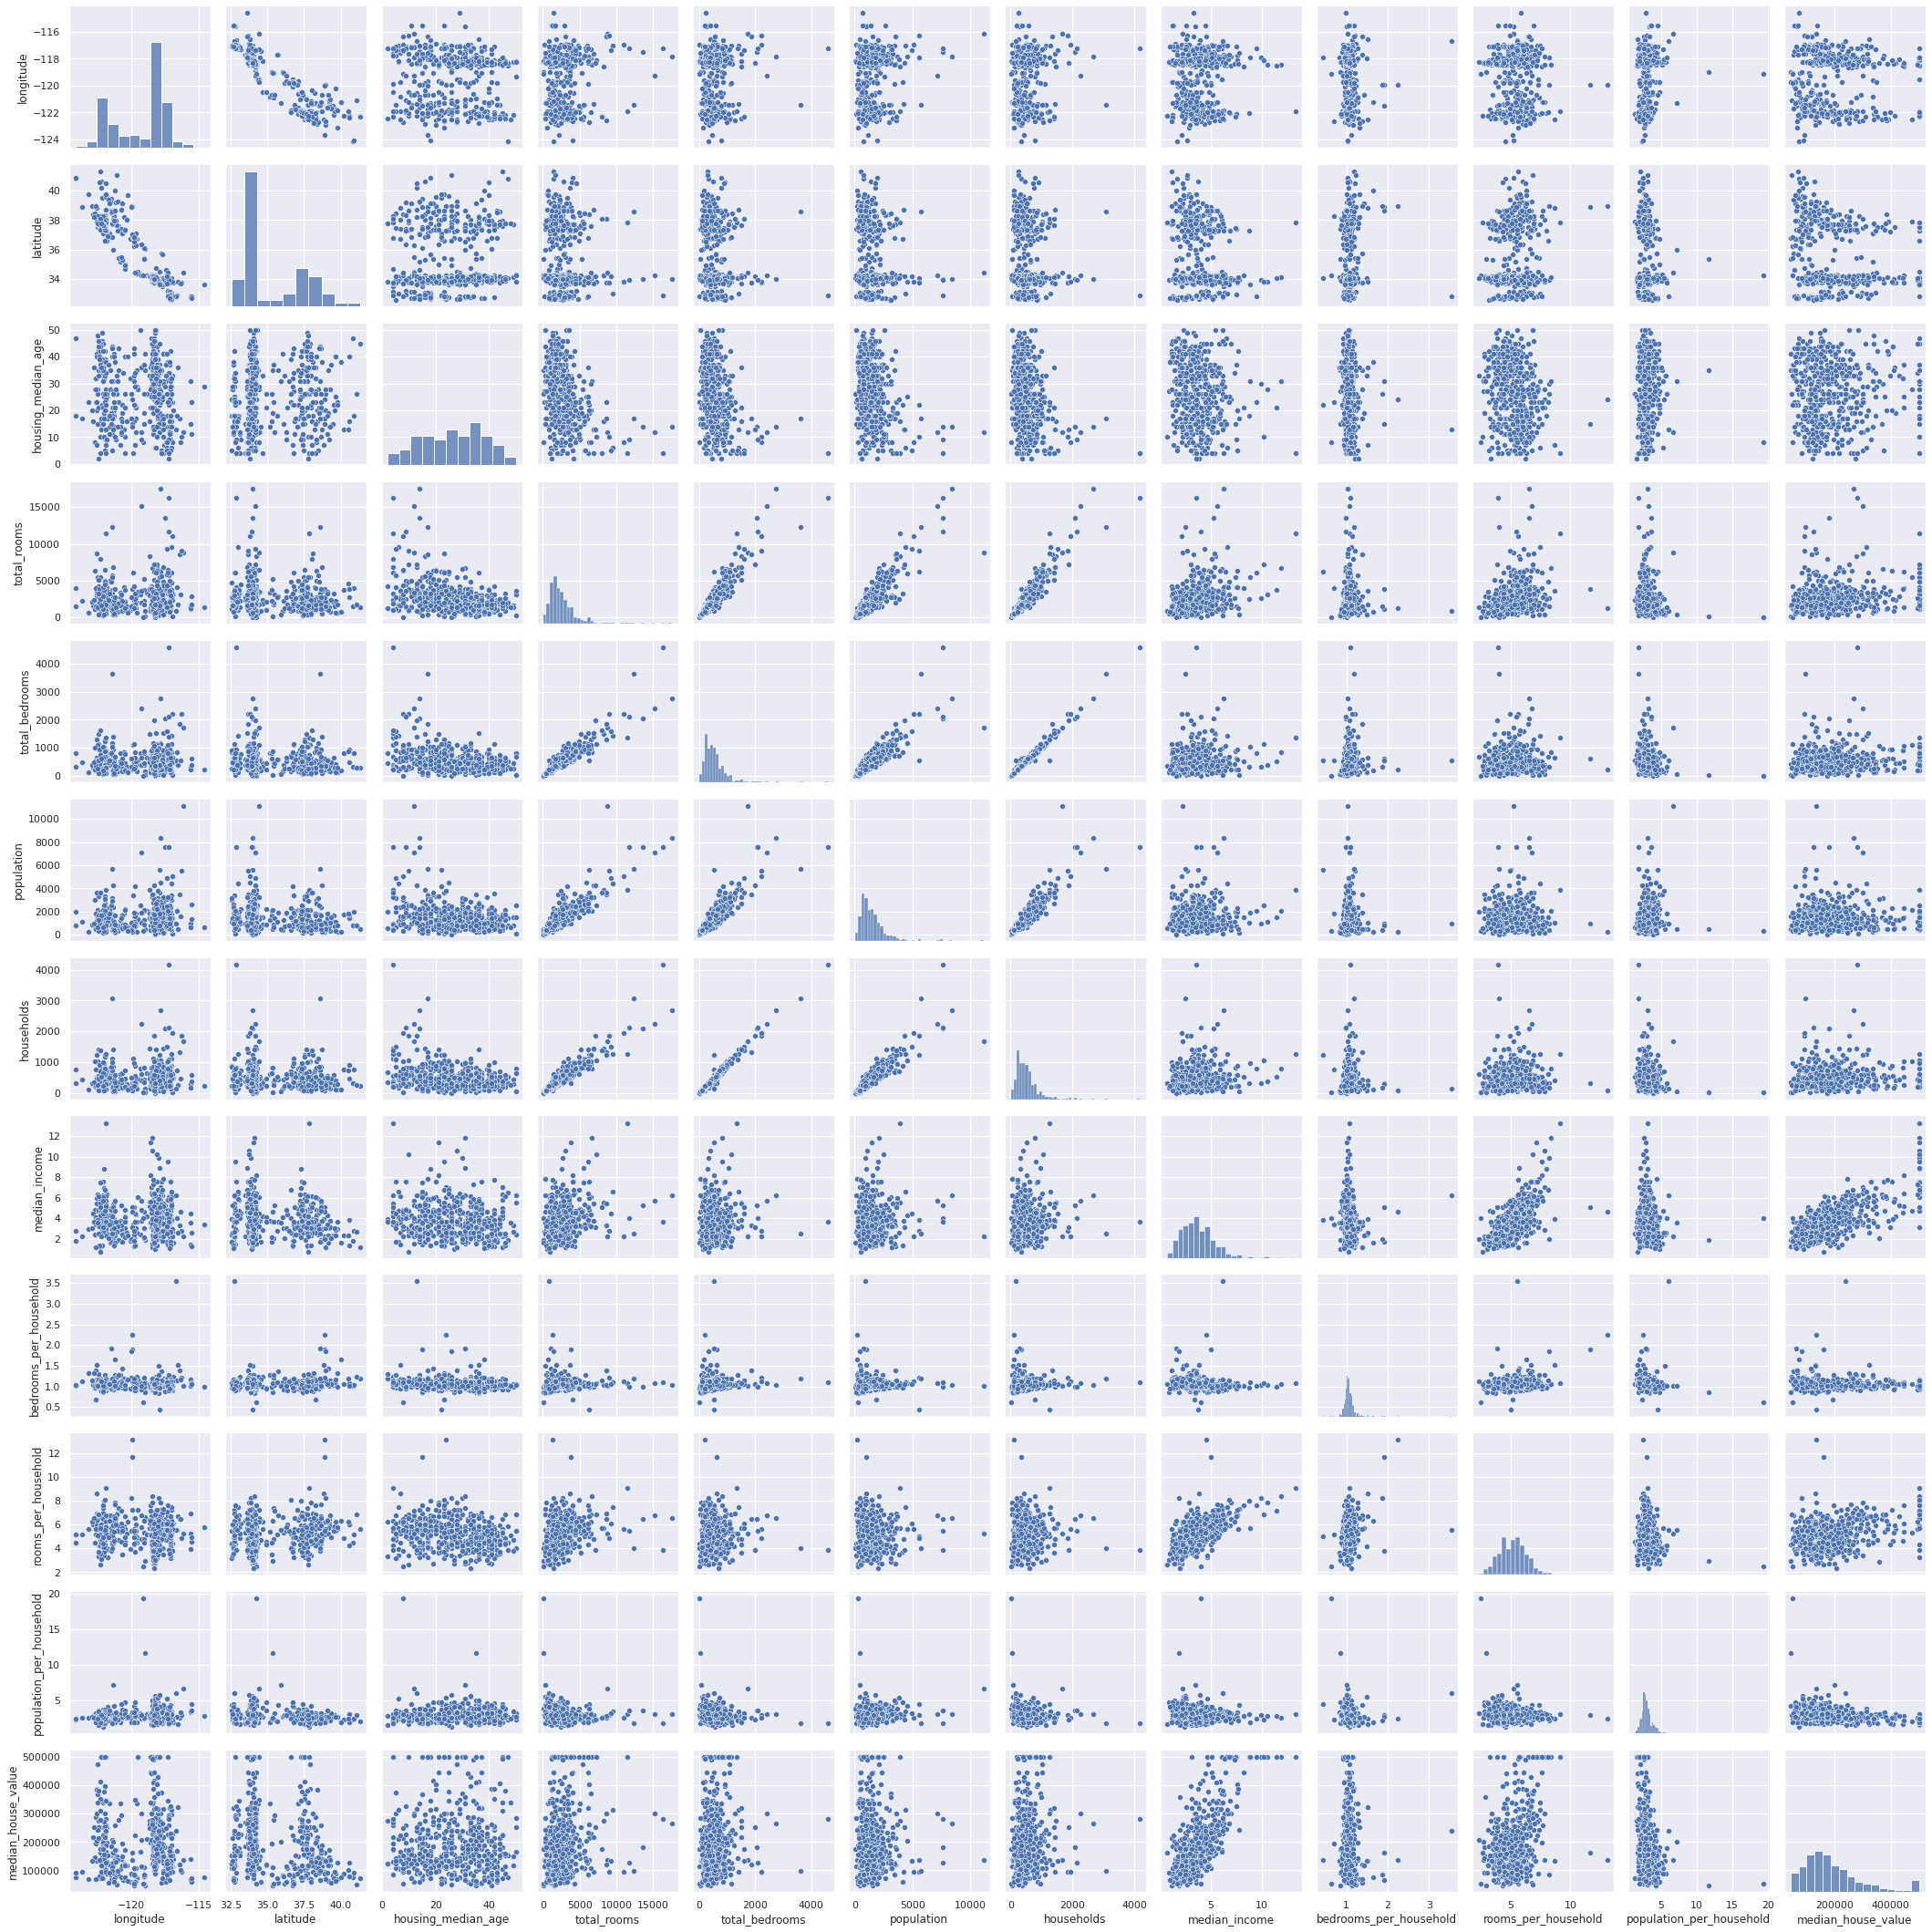

In [ ]:
# Graph each combination of variable to look for additional correlations
sns.pairplot(cali_dataset_clean.sample(500), vars=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                 'total_bedrooms', 'population', 'households', 'median_income', 'bedrooms_per_household', 'rooms_per_household', 'population_per_household',
                                 'median_house_value'
])

In [ ]:
# 
# Create source data for training
from sklearn.model_selection import train_test_split

training_source = cali_dataset_clean.copy()
x_source = training_source.drop(columns=['median_house_value'])
y_source = training_source['median_house_value']

# **Create Linear Regression Models**

The following sections will create models from the sci-kit learn LinearRegression model using different parameters.

* Create a model using only the features that strongly correlate to the target dependent variable `median_house_value`
* Create a model using features that are moderately correlated to the target dependet variable `median_house_value`
* Create a model using all features available in the input data set.

## **Results**

Utilizing all features achieved an r2 score of `0.67` for the test data set.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
import statsmodels.api as sm

def run_linear_regression(X_train, X_test, Y_train, Y_test):
  lin_model = LinearRegression(fit_intercept=True, copy_X=True)
  lin_model.fit(X_train, Y_train)

  #print("{} is {:.4f}\n".format(boldStr("LinearRegression.score"), lin_model.score(X_train,Y_train)))

  # model evaluation for training set
  y_train_predict = lin_model.predict(X_train)
  rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
  r2 = r2_score(Y_train, y_train_predict)

  printmd("**The model performance for _training_ set**")
  printHorizontalRule()
  printmd('**RMSE** is {:.2f}'.format(rmse))
  printmd('**R2** score is {:.4f}'.format(r2))
  printmd('**Absolute mean error** is {:.2f}'.format(mean_absolute_error(y_train_predict, Y_train)))
  printmd('**Coef** is \n  {}'.format(lin_model.coef_))
  print("\n")

  # model evaluation for testing set
  y_test_predict = lin_model.predict(X_test)
  rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
  r2 = r2_score(Y_test, y_test_predict)

  printmd("**The model performance for _testing_ set**")
  printHorizontalRule()
  printmd('**RMSE** is {:.2f}'.format(rmse))
  printmd('**R2** score is {:.4f}'.format(r2))
  printmd('**Absolute mean error** is {:.2f}'.format(mean_absolute_error(Y_test, y_test_predict)))
  print()

  printmd("**OLS performance**")
  printHorizontalRule()
  X_train = sm.add_constant(X_train)
  model = sm.OLS(Y_train, X_train)

  results = model.fit()
  printmd("**OLS R2** is {:.4f}".format(results.rsquared))
  print()

  print(results.summary())
  results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#
# Create linear regression model using only location and median_income which has the highest correlation
# 
X = x_source[['longitude', 'latitude', 'median_income']]
Y = y_source

# Split data into two groups, one to train on and one for testing.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=5)

printmd("# Linear regression using location and median_income")
print()

run_linear_regression(X_train, X_test, Y_train, Y_test)

# Linear regression using location and median_income

**The model performance for _training_ set**

---

**RMSE** is 70894.42

**R2** score is 0.6003

**Absolute mean error** is 52287.02

**Coef** is 
  [-46383.8245764  -46700.60423751  37321.69837484]

**The model performance for _testing_ set**

---

**RMSE** is 70268.96

**R2** score is 0.6112

**Absolute mean error** is 51441.56

**OLS performance**

---

**OLS R2** is 0.6003


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     7221.
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:25:03   Log-Likelihood:            -1.8161e+05
No. Observations:               14427   AIC:                         3.632e+05
Df Residuals:                   14423   BIC:                         3.632e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.823e+06    7.3e+04    -52.38

In [ ]:
#
# Create linear regression model using only the variables are are most highly correlated to median_house_value
# 
X = x_source[['longitude', 'latitude', 'median_income', 'INLAND', 'population_per_household', 'rooms_per_household']]
Y = y_source

# Split data into two groups, one to train on and one for testing.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=5)

printmd("# Linear regression using moderately correlated variables")
printmd("* `median_income`")
printmd("* `INLAND`")
printmd("* `population_per_household`")
printmd("* `rooms_per_household`")

print()

run_linear_regression(X_train, X_test, Y_train, Y_test)

# Linear regression using moderately correlated variables

* `median_income`

* `INLAND`

* `population_per_household`

* `rooms_per_household`

**The model performance for _training_ set**

---

**RMSE** is 66237.28

**R2** score is 0.6511

**Absolute mean error** is 47882.62

**Coef** is 
  [-27807.99414753 -28687.80079199  36717.85396794 -40232.39600969
 -25791.61799398  -1672.35498863]

**The model performance for _testing_ set**

---

**RMSE** is 65634.72

**R2** score is 0.6608

**Absolute mean error** is 47228.29

**OLS performance**

---

**OLS R2** is 0.6511


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     4485.
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:25:03   Log-Likelihood:            -1.8063e+05
No. Observations:               14427   AIC:                         3.613e+05
Df Residuals:                   14420   BIC:                         3.613e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                  

In [ ]:
#
# Try to improve score by using all available features
#
X_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN',
       'bedrooms_per_household', 'rooms_per_household', 'population_per_household']

X_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN', 
       'bedrooms_per_household', 'rooms_per_household', 'population_per_household']
       
X = x_source[X_features]
Y = y_source

# Split data into two groups, one to train on and one for testing.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=5)

printmd("# Linear regression using _all_ features")
print()

run_linear_regression(X_train, X_test, Y_train, Y_test)

# Linear regression using _all_ features

**The model performance for _training_ set**

---

**RMSE** is 64974.50

**R2** score is 0.6643

**Absolute mean error** is 46876.05

**Coef** is 
  [-2.78211658e+04 -2.73493876e+04  8.04197872e+02 -5.40672110e+00
  3.46909734e+01 -1.51817032e+01  4.85489820e+01  3.92867695e+04
  1.39934874e+04 -2.42028116e+04 -5.99216336e+03  1.62014876e+04
  2.26188250e+04 -8.24465760e+02 -1.83099849e+04]

**The model performance for _testing_ set**

---

**RMSE** is 64675.45

**R2** score is 0.6707

**Absolute mean error** is 46752.18

**OLS performance**

---

**OLS R2** is 0.6643


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     2037.
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:25:03   Log-Likelihood:            -1.8035e+05
No. Observations:               14427   AIC:                         3.607e+05
Df Residuals:                   14412   BIC:                         3.608e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                  